In [27]:
from astroML.datasets import generate_mu_z
import urllib.request
import pandas as pd
import requests
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from scipy.stats import uniform
from sklearn.mixture import GaussianMixture
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
import scipy.stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from random import randint
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
import h5py
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from astroML.datasets import fetch_sdss_specgals
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from astroML.utils import completeness_contamination

In [2]:
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [3]:
list(f.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [4]:
q = f['q'][:]
z = f['z'][:]
mtot = f['mtot'][:]
det = f['det'][:]
snr = f['snr'][:]

In [5]:
(len(q))**0.5

4472.13595499958

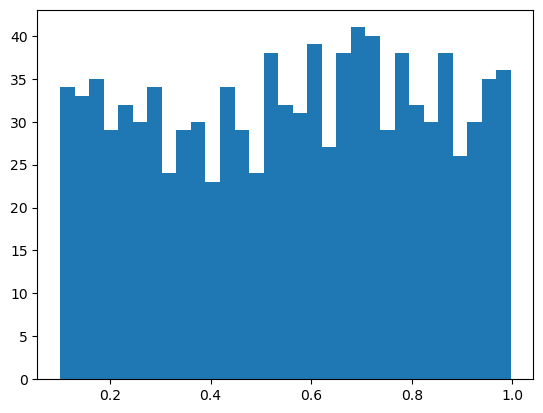

In [6]:
plt.hist(q[:1000], bins = int((len(q[:1000]))**0.5));

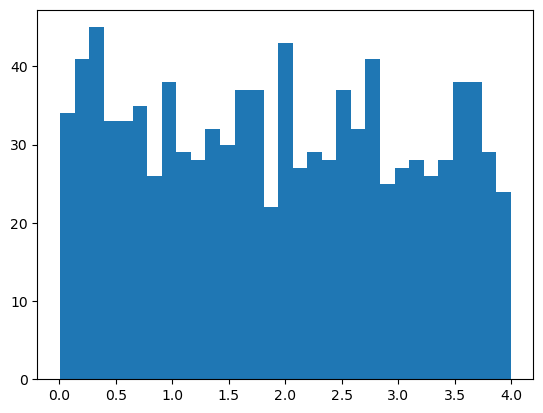

In [7]:
plt.hist(z[:1000], bins = int((len(z[:1000]))**0.5));

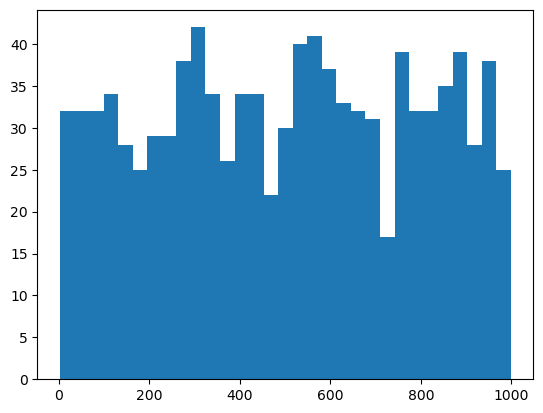

In [8]:
plt.hist(mtot[:1000], bins = int((len(mtot[:1000]))**0.5));

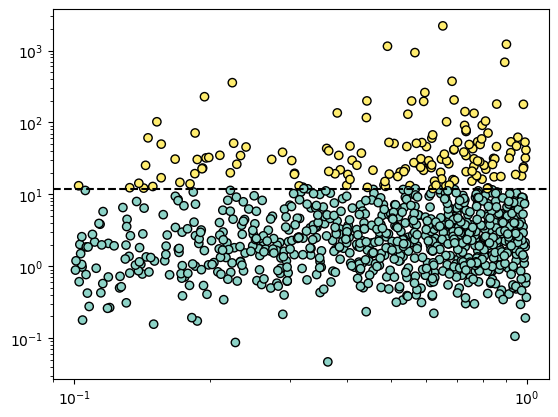

In [9]:
plt.scatter(q[:1000], snr[:1000], c=det[:1000], cmap='Set3', edgecolor='k')
plt.axhline(12, ls='--', color='black')
plt.loglog();

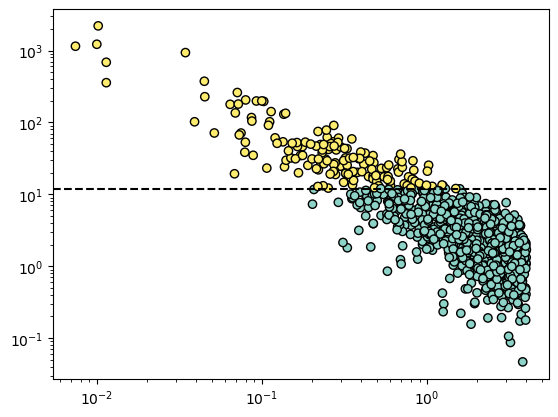

In [10]:
plt.scatter(z[:1000], snr[:1000], c=det[:1000], cmap='Set3', edgecolor='k')
plt.axhline(12, ls='--', color='black')
plt.loglog();

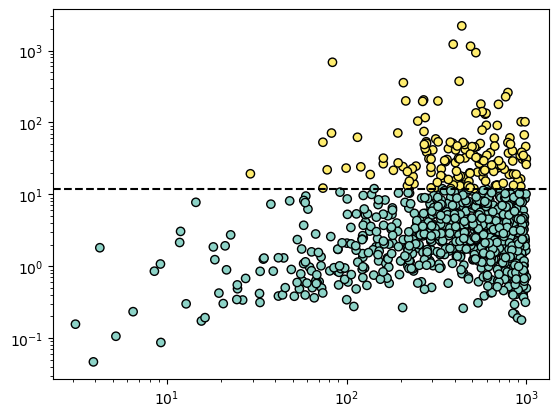

In [11]:
plt.scatter(mtot[:1000], snr[:1000], c=det[:1000], cmap='Set3', edgecolor='k')
plt.axhline(12, ls='--', color='black')
plt.loglog();

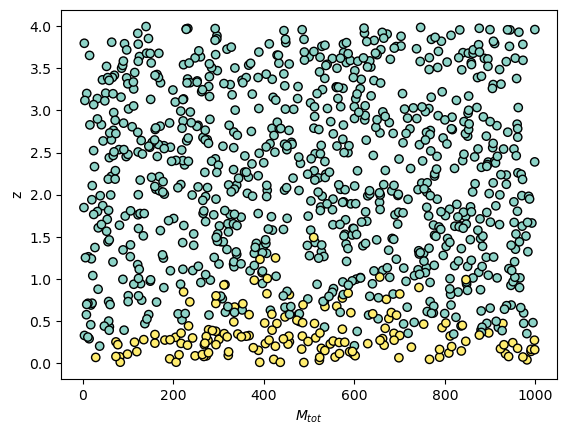

In [22]:
plt.scatter(mtot[:1000], z[:1000], c=det[:1000], cmap='Set3', edgecolor='k')
plt.xlabel(r'$M_{tot}$')
plt.ylabel('z');

## Decision Tree

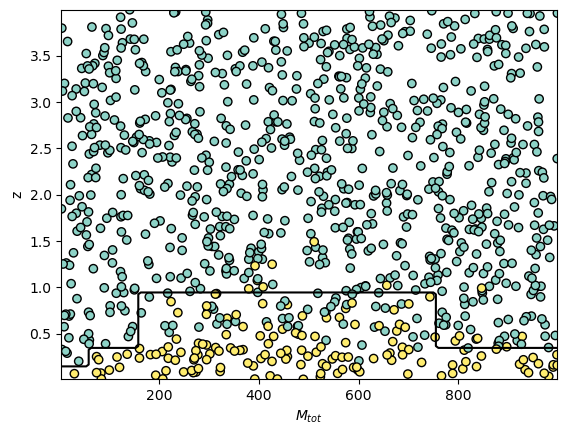

In [23]:
clf = DecisionTreeClassifier()
drange = np.arange(1,21)  #Complete
X = np.hstack([mtot[:1000, np.newaxis], z[:1000, np.newaxis]])
grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5) #Complete
grid.fit(X, det[:1000])

best = grid.best_params_['max_depth']
classifier = DecisionTreeClassifier(random_state=0, max_depth=best, criterion='entropy')
#X = np.hstack([mtot[:, np.newaxis], z[:, np.newaxis]])
classifier.fit(X, det[:1000])
yprob = classifier.predict_proba(X) # If we wanted probabilities rather than the discrete classes

xlim = (np.min(X[:,0]), np.max(X[:,0]))
ylim = (np.min(X[:,1]), np.max(X[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101), np.linspace(ylim[0], ylim[1], 101))
xystack = np.vstack([xx.ravel(),yy.ravel()])
Xgrid = xystack.T

Z = classifier.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
plt.scatter(mtot[:1000], z[:1000], c=det[:1000], cmap='Set3', edgecolor='k')
plt.xlabel(r'$M_{tot}$')
plt.ylabel('z')
plt.contour(xx, yy, Z, [0.5], colors='k');

## Kernel Methods

In [24]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    u = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    v = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    yy, xx = np.meshgrid(v, u)

    P = np.zeros_like(xx)
    for i, ui in enumerate(u):
        for j, vj in enumerate(v):
            Xgrid = np.array([ui, vj])
            P[i, j] = clf.decision_function(Xgrid.reshape(1,-1))
    return ax.contour(xx, yy, P, colors='k',
                      levels=[-1, 0, 1], ls = '-',# alpha=0.5,
                      linestyles=['--', '-', '--'])

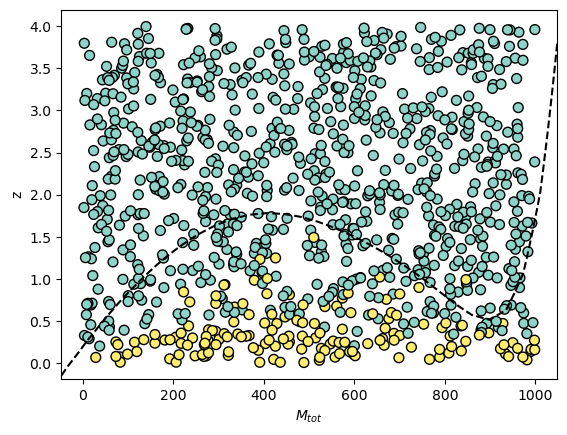

In [32]:
import warnings
warnings.filterwarnings("ignore")

clf = SVC(kernel='rbf',C=10)
clf.fit(X, det[:1000])
y_pred = clf.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=det[:1000], s=50, cmap='Set3', edgecolor='k')
plt.xlabel(r'$M_{tot}$')
plt.ylabel('z')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], 
            clf.support_vectors_[:, 1],
            s=200, facecolors='none');

In [33]:
completeness, contamination = completeness_contamination(y_pred, det[:1000])

In [34]:
print('Completeness: %f\nContamination: %f' %(completeness, contamination))

Completeness: 0.000000
Contamination: 0.000000


## Support Vector Machines

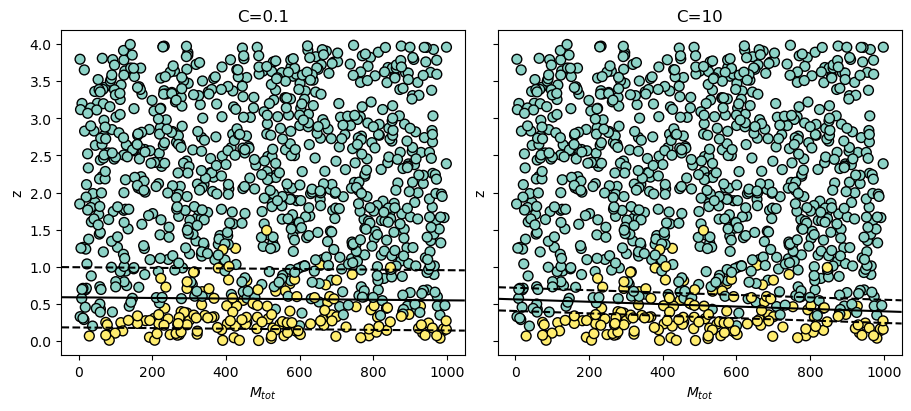

In [21]:
C = [0.1, 10]
a=0
fig = plt.figure(figsize=(9, 4), layout="constrained")
axs = fig.subplots(1, 2, sharex=True, sharey=True)
for c in C:
    svm = SVC(kernel='linear', C=c)
    svm.fit(X,det[:1000])
    
    axs[a].scatter(X[:, 0], X[:, 1], c=det[:1000], s=50, cmap='Set3', edgecolor='k')
    u = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    v = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    yy, xx = np.meshgrid(v, u)
    
    P = np.zeros_like(xx)
    for i, ui in enumerate(u):
        for j, vj in enumerate(v):
            Xgrid = np.array([ui, vj])
            P[i, j] = svm.decision_function(Xgrid.reshape(1,-1))
    axs[a].contour(xx, yy, P, colors='k', levels=[-1, 0, 1], ls = '-', linestyles=['--', '-', '--'])
    axs[a].set_title('C='+str(C[a]))
    axs[a].set_xlabel(r'$M_{tot}$')
    axs[a].set_ylabel('z')
    a = a+1
plt.show()